# Taller 1 (Individual)

* Implementar los algoritmos de interpolación usando:
    * Nearest Neighbohr
    * Bilineal
    * Bicubico
    
Aumentar la resolución de la imagen en un número entero. Es decir $I \rightarrow NxN$, la imagen interpolada debe ser de tamaño $kN \times kN$ donde $k \in \mathbb Z$ y $k > 1$. 

**Fecha de entrega (11 feb)**

* Debe estar implementado en una gui, que sea fácil de usar:
    * Cargar la imagen.
    * Seleccionar k.
    * Mostrar la imagen original y la interpolada.

* Debe haber anáisis de resultados

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

(531, 531, 3)


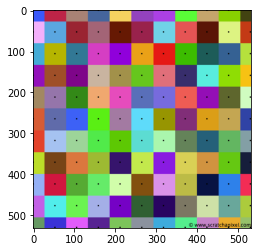

In [7]:
img = cv2.imread("./imgs/test_image.png")
#img = cv2.imread("./imgs/diomedes.jpg")
print(img.shape)
plt.imshow(img)

In [8]:
def izi_plot(img: np.ndarray, new_image: np.ndarray):
    
    fig, axs = plt.subplots(1, 2,  figsize=(15,12))
    axs[0].imshow(new_image)   
    axs[0].set_title("Imagen Reescalada")
    axs[1].imshow(img)
    axs[1].set_title("Imagen Original")
    plt.show()

## Resize usando nearest neighbor:

* la idea para hacer esta interpolación fácilmente viene de [aquí](https://www.imageeprocessing.com/2017/11/nearest-neighbor-interpolation.html)

In [4]:

def resize_image_nearest_neighbor(img: np.ndarray, scaling: int):
    
    if scaling < 1:
        raise "scaling must be greater than 1!"
    
    # obtiene las dimensiones de la imagen inicial
    rows, cols, nchannels = img.shape
    
    # crea las dimensiones para la imagen reescalada
    new_rows = rows*scaling
    new_cols = cols*scaling
    
    # crea una matriz para la nueva imagen
    new_image = np.zeros((new_rows, new_cols, nchannels))

    # genero los indices de 1 hasta el numero nuevo de filas
    # y para que me quede en el rango de la imagen original 
    # divido función piso en el escalamiento
    
    row_idxs = np.int32( np.floor(np.arange(new_rows)/scaling) )
    col_idxs = np.int32( np.floor(np.arange(new_cols)/scaling) )

    
    for c in range(nchannels):
        
        # genero una variable temporal y me quedo solo con 
        # las filas requeridas del canal solicitado
        temp = img[row_idxs,:,c]
        
        # de las filas con las que me quedé 
        # paso a quedarme (y repetir) las columnas que 
        # corresponden
        new_image[:,:, c] = temp[:,col_idxs]
        
    #convierte la matriz a uint8 para poderla visualizar
    new_image = np.uint8(new_image)


    
    return new_image


Observe que las dimensiones de la imagen se ampliaron **(el rango en x e y del plot es más grande)**

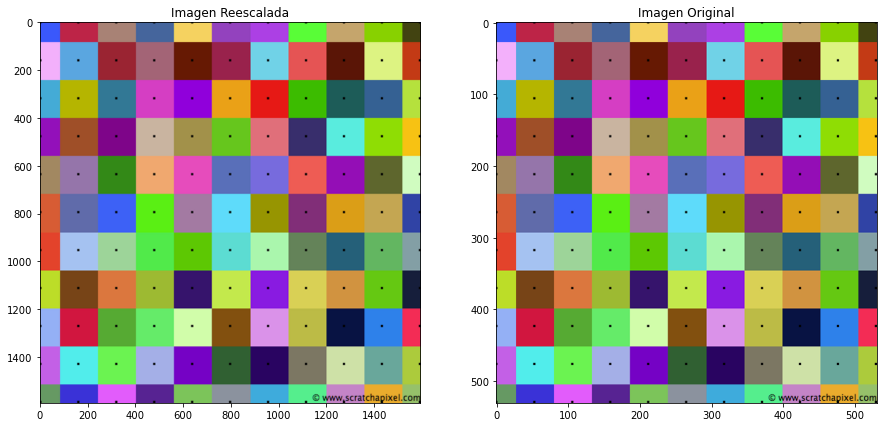

In [5]:
re_img_neighbor = resize_image_nearest_neighbor(img, 3)
izi_plot(img, re_img_neighbor)

## Resize usando interpolación bilineal:

Interpolación bilineal como interpolación de interpolación:

* [Aquí se explica intuitivamente como funciona esta aproximación](https://theailearner.com/2018/12/29/image-processing-bilinear-interpolation/)

* [Acá también se explica el concepto y se muestra una implementación tentativa](https://www.scratchapixel.com/lessons/mathematics-physics-for-computer-graphics/interpolation/bilinear-filtering) 

In [6]:
def bilineal_interp(dx, dy, c00, c01, c10, c11):
    
    a = ( c00 * (1 - dx) ) + c01 * dx
    b = ( c10 * (1 - dx) ) + c11 * dx

    return (a * (1 - dy) ) + b * dy
    

In [7]:
def resize_image_bilineal_interpolation(img: np.ndarray, scaling: int):
    
    if scaling < 1:
        raise "scaling must be greater than 1!"
    
    # obtiene las dimensiones de la imagen inicial
    rows, cols, nchannels = img.shape
    
    # crea las dimensiones para la imagen reescalada
    new_rows = rows*scaling
    new_cols = cols*scaling
    
    # crea una matriz para la nueva imagen
    new_image = np.zeros((new_rows, new_cols, nchannels))  
    
    # repite los bordes para poder hacer las operaciones más fácilmente
    img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_REPLICATE)

    # primero observe que np.arange(new_rows)/new_rows corresponde 
    # a un vector de porcentajes, luego al multiplicar por el numero
    # de filas que hay en la imagen original estamos obteniendo 
    # la posición sobre la imagen original
    # (esta variable será util para generar indexados y dar pesos)
    absolute_row_idx = (np.arange(new_rows)* rows ) /new_rows
    absolute_col_idx = (np.arange(new_cols)* cols ) /new_cols

    # creamos los indices de los vecinos más cercanos
    row_idx_prev = np.int32(np.floor(absolute_row_idx))
    row_idx_next = row_idx_prev + 1 
    col_idx_prev = np.int32(np.floor(absolute_col_idx))
    col_idx_next = col_idx_prev + 1 
    
    # vector de distancias (que van a servir como pesos)
    dx = col_idx_next - absolute_col_idx
    dy = row_idx_next - absolute_row_idx
    
    for i in range(new_rows):
        for j in range(new_cols):
            for c in range(nchannels):
                new_image[i, j, c] = bilineal_interp(dx[j], dy[i],
                                                 img[row_idx_prev[i], col_idx_prev[j], c],
                                                 img[row_idx_prev[i], col_idx_next[j], c],
                                                 img[row_idx_next[i], col_idx_prev[j], c],
                                                 img[row_idx_next[i], col_idx_next[j], c])

               
    
    new_image = np.uint8(new_image)
    
    return new_image
    
            
            
    

In [8]:
re_img_bilinear = resize_image_bilineal_interpolation(img, 2)

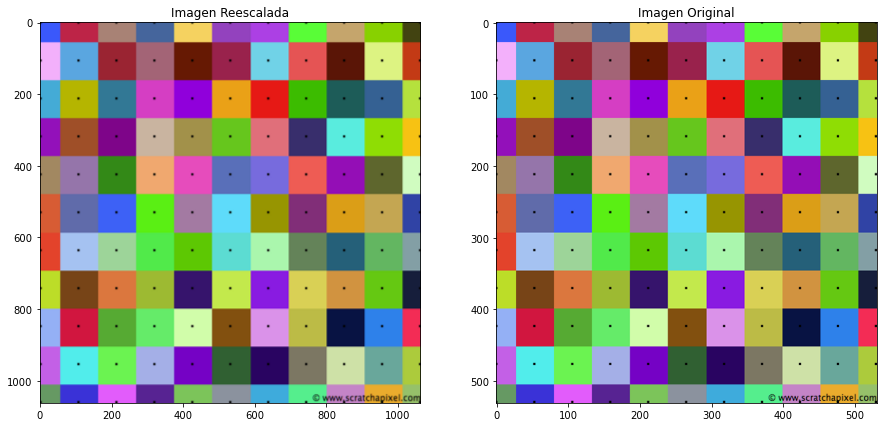

In [9]:
izi_plot(img, re_img_bilinear)

Esta forma de ver el problema como la interpolación de interpolaciones funciona, sin embargo es muy lenta debido al ciclo triple anidado para generar las interpolaciones. Otra forma más favorable de entender el problema es como un promedio ponderado, esta manera puede dar pie a una versión vectorizada más bonita:

* [Bilinear interpolation as weighted mean](https://en.wikipedia.org/wiki/Bilinear_interpolation#Weighted_mean)
* [Implementación vectorizada más bonita](https://stackoverflow.com/questions/12729228/simple-efficient-bilinear-interpolation-of-images-in-numpy-and-python) 
* [implementación que repliqué usando las fórmular presentadas acá y el código](https://chao-ji.github.io/jekyll/update/2018/07/19/BilinearResize.html)

In [32]:
def resize_image_bilineal_interpolation2_one_channel(img: np.ndarray, scaling: int):
    
    if scaling < 1:
        raise "scaling must be greater than 1!"
    
    # obtiene las dimensiones de la imagen inicial
    nrows, ncols = img.shape
    
    # crea las dimensiones para la imagen reescalada
    new_nrows = nrows*scaling
    new_ncols = ncols*scaling
    
    # ratio de ampliación (se le resta uno por que 
    # en python se indexa desde 0)
    row_ratio = (nrows-1)/(new_nrows-1)
    col_ratio = (ncols-1)/(new_ncols-1)
        
    # aplana la imagen original
    img = img.ravel()

    # divmod retorna el cociente de la división y el residuo
    # en este caso el cociente corresponde a el número de fila 
    # y el residuo al número de columna en la matriz
    rows_idxs, cols_idxs = np.divmod(np.arange(new_nrows * new_ncols), new_ncols)

    # da las posiciones relativas en fila y columna
    # serán útiles para crear un indexado de vecinos
    # y asignar pesos, note que row_pos estará entre [0, nrows-1]
    rows_pos = rows_idxs * row_ratio
    cols_pos = cols_idxs * col_ratio
        
    # creamos los indices de los vecinos más cercanos
    row_prev = np.int32( np.floor(rows_pos) )
    row_next = np.int32( np.ceil(rows_pos)  )
    col_prev = np.int32( np.floor(cols_pos) )
    col_next = np.int32( np.ceil(cols_pos)  )

    row_weight = (rows_pos) - row_prev
    col_weight = (cols_pos) - col_prev
    
    img11 = img[row_prev*ncols + col_prev]
    img12 = img[row_prev*ncols + col_next]
    img21 = img[row_next*ncols + col_prev]
    img22 = img[row_next*ncols + col_next]
        
    local_img = img11 * (1 - col_weight) * (1 - row_weight) + \
                img12 * col_weight * (1 - row_weight) + \
                img21 * row_weight * (1 - col_weight) + \
                img22 * col_weight * row_weight

    new_image = local_img.reshape((new_nrows, new_ncols))
    new_image = np.uint8(new_image)
    
    return new_image
    
def resize_image_bilineal_interpolation2(img: np.ndarray, scaling: int):
    
    nrows, ncols, nchannels = img.shape
    new_img = np.zeros((nrows*scaling, ncols*scaling, nchannels))
    
    for c in range(nchannels):
        #new_img[:,:,c] = bilinear_resize_vectorized(img[:,:,c], nrows*scaling, ncols*scaling)
        new_img[:,:,c] = resize_image_bilineal_interpolation2_one_channel(img[:,:,c], scaling)  
        
    return new_img.astype("uint8")
    

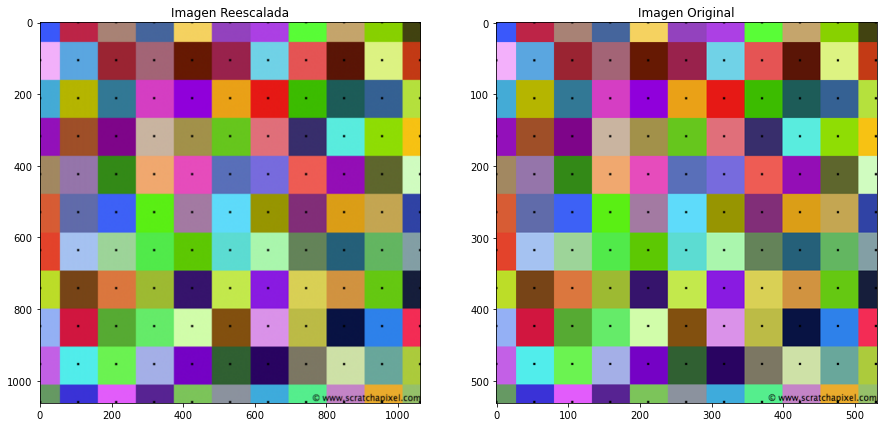

In [33]:
re_img_bilinear2 = resize_image_bilineal_interpolation2(img, 2)
izi_plot(img, re_img_bilinear2)

## Resize usando interpolación bicubica

* [leer este](https://programmer.help/blogs/image-interpolation-theory-and-python-implementation.html)
* revisar las distintas aproximaciones para hacer interpolación bicubica [lagrange](https://en.wikipedia.org/wiki/Lagrange_polynomial), [cubic hermite spline](https://en.wikipedia.org/wiki/Cubic_Hermite_spline), [bicubic convolution](https://en.wikipedia.org/wiki/Bicubic_interpolation#Bicubic_convolution_algorithm)


In [1]:
def bicubic_interpolate1(p0, p1, p2, p3, x):
    return  (-p0/2 + 3*p1/2 - 3*p2/2 + p3/2)*(x**3) +\
            (p0 - 5*p1/2 + 2*p2 - p3/2)*(x**2) +\
            (-p0/2 + p2/2)*(x) + p1

In [4]:
def bicubic_interpolate2(p0, p1, p2, p3, x):
    return  np.multiply( (-p0/2 + 3*p1/2 - 3*p2/2 + p3/2), (x**3) ) +\
            np.multiply( (p0 - 5*p1/2 + 2*p2 - p3/2), (x**2)) +\
            np.multiply( (-p0/2 + p2/2), x) + p1

In [52]:
def resize_image_bicubic_interpolation_one_channel(img: np.ndarray, scaling: int):
    
    # obtiene las dimensiones de la imagen inicial
    nrows, ncols = img.shape
    
    # crea las dimensiones para la imagen reescalada
    new_nrows = nrows*scaling
    new_ncols = ncols*scaling
    
    # crea la matriz de la imagen reescalada
    new_img = np.zeros((new_nrows, new_ncols))
    
    # repite los bordes para poder hacer las operaciones más fácilmente
    img = cv2.copyMakeBorder(img, left=2, right=2, top=2, bottom=2, borderType = cv2.BORDER_REPLICATE)

    # aplana la imagen
    img = img.ravel()
    
    # obtiene un indexado de filas y columnas para 
    # la iamgen original
    rows_idxs, cols_idxs = np.divmod(np.arange(new_nrows*new_ncols), new_ncols)
    
    # para poner estos índices en la escala de indices 
    # de la matriz original, multiplicamos por los siguientes
    # factores de escalamiento 
    row_scaling = (nrows - 1)/(new_nrows - 0)
    col_scaling = (ncols - 1)/(new_ncols - 0)
    
    # ahora si ponemos los indices de filas y columnas 
    # en escala de la imagen original
    row_pos = row_scaling * rows_idxs
    col_pos = col_scaling * cols_idxs
    
    """
    row_pos = (row_scaling + 1)* rows_idxs
    col_pos = (col_scaling + 1* cols_idxs
    """
    
    print(rows_idxs.astype('int32'))
    
    prev_row = np.floor(row_pos*ncols).astype('int32')
    next_row = np.ceil(row_pos*ncols).astype('int32')
    
    #pixeles de la izquierda y la derecha de la fila 1
    pix_ll1 = img[ prev_row + new_ncols ]
    pix_l1  = img[ next_row + new_ncols ]
    pix_r1  = img[ prev_row + new_ncols + 1]
    pix_rr1 = img[ next_row + new_ncols + 1]
    
    #pixeles de la izquierda y la derecha de la fila 2
    pix_ll2 = img[ prev_row + ncols + new_ncols ]
    pix_l2  = img[ next_row + ncols + new_ncols ]
    pix_r2  = img[ prev_row + ncols + new_ncols + 1]
    pix_rr2 = img[ next_row + ncols + new_ncols + 1]
    
    #pixeles de la izquierda y la derecha de la fila 3
    pix_ll3 = img[ prev_row + ncols*2 + new_ncols ]
    pix_l3  = img[ next_row + ncols*2 + new_ncols ]
    pix_r3  = img[ prev_row + ncols*2 + new_ncols + 1]
    pix_rr3 = img[ next_row + ncols*2 + new_ncols + 1]
    
    #pixeles de la izquierda y la derecha de la fila 4
    pix_ll4 = img[ prev_row + ncols*3 + new_ncols ]
    pix_l4  = img[ next_row + ncols*3 + new_ncols ]
    pix_r4  = img[ prev_row + ncols*3 + new_ncols + 1]
    pix_rr4 = img[ next_row + ncols*3 + new_ncols + 1]
    
    #new_img[0:new_nrows:scaling, 0:new_ncols:scaling] = img
    
    print(pix_ll1.shape)
    print(pix_l1.shape)
    print(pix_r1.shape)
    print(pix_rr1.shape)
    print('-------------')
    print(row_pos.shape)
    print('-------------')
    print(new_nrows*new_ncols)
    
    row1 = bicubic_interpolate2(pix_ll1, pix_l1, pix_r1, pix_rr1, row_pos)
    row2 = bicubic_interpolate2(pix_ll2, pix_l2, pix_r2, pix_rr2, row_pos)
    row3 = bicubic_interpolate2(pix_ll3, pix_l3, pix_r3, pix_rr3, row_pos)
    row4 = bicubic_interpolate2(pix_ll4, pix_l4, pix_r4, pix_rr4, row_pos)
    
    new_img = bicubic_interpolate2(row1, row2, row3, row4, col_pos)

    
    """
    for i in rows_idxs.astype('int32'):
        for j in cols_idxs.astype('int32'):
            
            row1 = bicubic_interpolate(img[i*ncols + j-1], img[i*ncols + j], 
                                       img[i*ncols + j+1], img[i*ncols + j+2], row_scaling*i)
            row2 = bicubic_interpolate(img[i*ncols + j-1], img[i*ncols + j],
                                       img[i*ncols + j+1], img[i*ncols + j+2], row_scaling*i)
            row3 = bicubic_interpolate(img[i*ncols + j-1], img[i*ncols + j],
                                       img[i*ncols + j+1], img[i*ncols + j+2], row_scaling*i)
            row4 = bicubic_interpolate(img[i*ncols + j-1], img[i*ncols + j],
                                       img[i*ncols + j+1], img[i*ncols + j+2], row_scaling*i)
            
            bicubic_interpolate(row1, row2, row3, row4, col_scaling*j)
    """ 
    
    new_img = new_img.reshape((new_nrows, new_ncols))
    new_img = new_img.astype('uint8')
    plt.imshow(new_img)
    pass

[   0    0    0 ... 1061 1061 1061]
(1127844,)
(1127844,)
(1127844,)
(1127844,)
-------------
(1127844,)
-------------
1127844


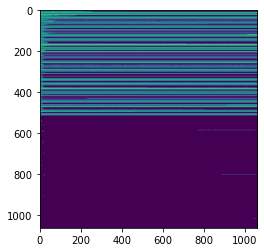

In [53]:
resize_image_bicubic_interpolation_one_channel(img[:,:,0], 2)